In [1]:
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType, StringType, IntegerType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql.functions import count, when, col
from pyspark.sql.dataframe import DataFrame
from pyspark.ml.stat import Correlation
from pyspark.sql.window import Window
from pyspark.mllib.stat import Statistics
from pyspark.ml.classification import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import math
import numpy as np

In [2]:
SEED = 12345
DATA_PATH = "/home/arthur/Documents/data-ds-case-23.parquet"

**What is the problem?** 

Approved transactions may generate chargebacks (total loss of value) or not (generating 15% of revenue). The goal is to develop a solution to prevent chargebacks and maximize profitability.

**What is the specific objectives?**

- Develop a model to predict chargebacks on transactions.
- Compare the performance of the solution with the other two providers.
- Evaluate the solution based on appropriate methodologies.

In [3]:
# Create a Spark session
spark = SparkSession.builder.appName("Incognia Chargeback Analysis").getOrCreate()

24/10/09 09:08:26 WARN Utils: Your hostname, arthur-Dell-G15-5511 resolves to a loopback address: 127.0.1.1; using 192.168.1.6 instead (on interface wlp0s20f3)
24/10/09 09:08:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/09 09:08:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/09 09:08:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
raw_data = spark.read.parquet(DATA_PATH)
raw_data = raw_data.withColumn("chargeback", col("chargeback").cast(StringType()))

In [5]:
# As said in the document, we can assume that all transactions were approved.
raw_data = raw_data.drop("status")

# Exploratory Data Analysis

In [6]:
print('Data overview')
raw_data.printSchema() # To see the structure and types of columns.

Data overview
root
 |-- dt: string (nullable = true)
 |-- id: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- account_id: string (nullable = true)
 |-- installation_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- f_boot_count: integer (nullable = true)
 |-- f_wallpaper_id: integer (nullable = true)
 |-- f_chargeback_rate_by_geohash_5_30d: float (nullable = true)
 |-- f_chargeback_rate_by_geohash_6_30d: float (nullable = true)
 |-- f_chargeback_rate_by_geohash_7_30d: float (nullable = true)
 |-- f_sum_values_by_ilm_id_30d: float (nullable = true)
 |-- f_sum_values_by_ilm_id_3d: float (nullable = true)
 |-- f_device_age_ms: long (nullable = true)
 |-- f_account_age_ms: long (nullable = true)
 |-- f_os: integer (nullable = true)
 |-- f_sum_values_by_device_id_30d: float (nullable = true)
 |-- f_sum_values_by_device_id_3d: float (nullable = true)
 |-- f_n_user_ids_by_device_id_30d: integer (null

In [7]:
print('Columns overview')
pd.DataFrame(raw_data.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,dt,string
1,id,string
2,device_id,string
3,account_id,string
4,installation_id,string
5,timestamp,timestamp
6,total_amount,float
7,f_boot_count,int
8,f_wallpaper_id,int
9,f_chargeback_rate_by_geohash_5_30d,float


In [8]:
print('Data frame describe (string and numeric columns only):')
raw_data.describe().show()

Data frame describe (string and numeric columns only):


24/10/09 09:08:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+----------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+----------------------------------+----------------------------------+----------------------------------+--------------------------+-------------------------+--------------------+--------------------+------------------+-----------------------------+----------------------------+-----------------------------+----------------------------------+------------------+---------------------+---------------------------+--------------------+-------------------------+--------------------+----------+----------+
|summary|        dt|                  id|           device_id|          account_id|     installation_id|      total_amount|      f_boot_count|    f_wallpaper_id|f_chargeback_rate_by_geohash_5_30d|f_chargeback_rate_by_geohash_6_30d|f_chargeback_rate_by_geohash_7_30d|f_sum_values_by_ilm_id_30d|f_sum_values_by_ilm_id_3d|     f_device_age

In [9]:
print(f'There are total {raw_data.count()} row, Let print first 2 data rows:')
raw_data.limit(2).show()

There are total 795021 row, Let print first 2 data rows:
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+------------+--------------+----------------------------------+----------------------------------+----------------------------------+--------------------------+-------------------------+---------------+----------------+----+-----------------------------+----------------------------+-----------------------------+----------------------------------+--------------+---------------------+---------------------------+--------------------+-------------------------+------------------+----------+----------+
|        dt|                  id|           device_id|          account_id|     installation_id|           timestamp|total_amount|f_boot_count|f_wallpaper_id|f_chargeback_rate_by_geohash_5_30d|f_chargeback_rate_by_geohash_6_30d|f_chargeback_rate_by_geohash_7_30d|f_sum_values_by_ilm_id_30d|f_sum_values_by_ilm_i

- There are missing values in columns like `f_boot_count`, `f_wallpaper_id`, and `f_chargeback_rate_*`. I will need to handle these missing values appropriately during preprocessing. 
- Some columns have wide ranges of values, as seen in `f_total_events` and `f_device_age_ms`, which might require **normalization or scaling during model training**.
- Columns like `provider`, and others show up as *NULL* under the mean and stddev columns. These are likely categorical columns where NULL values aren't applicable for numerical summary statistics but could be relevant in analyses.

## Feature Analysis

We will organize the variables based on the data type and give a short description to each variable.

- Numerical:
    - `total_amount`: Total transaction amount.
    - `f_boot_count`: Number of times the device has been rebooted.
    - `f_wallpaper_id`: Wallpaper ID on the device.
    - `f_chargeback_rate_by_geohash_5_30d`: Chargeback rate by geographic region (low precision) in the last 30 days.
    - `f_chargeback_rate_by_geohash_6_30d`: Chargeback rate by geographic region (medium precision) in the last 30 days.
    - `f_chargeback_rate_by_geohash_7_30d`: Chargeback rate by geographic region (high precision) in the last 30 days. 
    - `f_sum_values_by_ilm_id_30d`: Sum of transactional values from the installation in the last 30 days
    - `f_sum_values_by_ilm_id_3d`: sum of transactional values from the installation in the last 3 days
    - `f_device_age_ms`: Age of the device in milliseconds.
    - `f_account_age_ms`: Age of the account in milliseconds.
    - `f_sum_values_by_device_id_30d`: Sum of transactional values from the device in the last 30 days
    - `f_sum_values_by_device_id_3d`: Sum of transactional values from the device in the last 3 days
    - `f_n_user_ids_by_device_id_30d`: Number of users per device in the last 30 days. 
    - `f_n_installations_by_device_id_30d`: Number of installations by device in the last 30 days.
    - `f_total_events`: Total number of transactions related to the device.
    - `f_total_installations`: Device's locations - number of installations
    - `f_total_fraud_installations`: Total number of fraudulent installationss associated with the device.
    - `f_total_fraud_events`: Total number of fraudulent events associated with the device.
    - `f_avg_fraud_installations`: Average rate of fraudulent installationss associated with the device.
    - `f_avg_fraud_events`: Average rate of fraudulent events associated with the device.

- Categorical:
    - `id`: Transaction ID.
    - `device_id`: Device ID.
    - `account_id`: Account ID.
    - `installation_id`: Installation ID.
    - `f_os`: Device operating system.
    - `chargeback`: Indicates whether the transaction generated a chargeback (true/false).
    - `provider`: Indicates the provider associated with the transaction (EXTERNAL_1, EXTERNAL_2, YOU).

- Timestamps:
    - `dt`: Transaction date (in date format).
    - `timestamp`: Unix timestamp for the transaction.

In [10]:
original_categorical_features = ['id', 'device_id', 'account_id', 'installation_id', 'f_os', 'chargeback', 'provider']
original_numerical_features = [
    'total_amount', 'f_boot_count', 'f_wallpaper_id', 'f_chargeback_rate_by_geohash_5_30d', 'f_chargeback_rate_by_geohash_6_30d', 
    'f_chargeback_rate_by_geohash_7_30d', 'f_sum_values_by_ilm_id_30d', 'f_sum_values_by_ilm_id_3d', 'f_device_age_ms', 'f_account_age_ms',
    'f_sum_values_by_device_id_30d', 'f_sum_values_by_device_id_3d', 'f_n_user_ids_by_device_id_30d', 'f_n_installations_by_device_id_30d',
    'f_total_events', 'f_total_installations', 'f_total_fraud_installations', 'f_total_fraud_events', 'f_avg_fraud_installations', 'f_avg_fraud_events'
]
original_timestamp_features = ["dt", "timestamp"]

### Timestamp features

In [34]:
# Function to calculate temporal features
def calculate_temporal_features(df):
    # Add day of the week
    df = df.withColumn('day_of_week', F.dayofweek('timestamp'))
    # Add day of the month
    df = df.withColumn('day_of_month', F.dayofmonth('timestamp'))
    # Add month
    df = df.withColumn('month', F.month('timestamp'))
    # Add hour of day
    df = df.withColumn('hour_of_day', F.hour('timestamp'))
    # Add seconds from midnight
    df = df.withColumn('seconds_from_midnight', F.unix_timestamp('timestamp') % 86400)
    # Add period of the day
    df = df.withColumn(
        'day_period', 
        F.when(F.col('hour_of_day') < 6, 'Dawn')
        .when((F.col('hour_of_day') >= 6) & (F.col('hour_of_day') < 12), 'Morning')
        .when((F.col('hour_of_day') >= 12) & (F.col('hour_of_day') < 18), 'Afternoon')
        .otherwise('Night')
    )
    df = df.withColumn(
        'season', when((df.month >= 3) & (df.month <= 5), 'Spring')
        .when((df.month >= 6) & (df.month <= 8), 'Summer')
        .when((df.month >= 9) & (df.month <= 11), 'Autumn')
        .otherwise('Winter')
    )
    # Add transaction count and sum of values over the last 30 days (temporal aggregations)
    window_spec = Window.partitionBy("device_id").orderBy(F.col("timestamp").cast("long")).rangeBetween(-30 * 86400, 0)
    df = df.withColumn("transaction_count_last_30_days", F.count("id").over(window_spec))
    df = df.withColumn("sum_values_last_30d", F.sum("total_amount").over(window_spec))
    
    return df

temporal_features = ['timestamp', 'day_of_week', 'day_of_month', 'month', 'hour_of_day', 'seconds_from_midnight', 'day_period', 'transaction_count_last_30_days', 'sum_values_last_30d', 'chargeback']

# Apply function to calculate temporal features
data_with_temporal_features = calculate_temporal_features(raw_data).select(*temporal_features)

# Convert to Pandas for visualization
data_pd = data_with_temporal_features.toPandas()

In [31]:
def plot_histogram(df, col, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=False, bins=30, color='blue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def plot_bar(df, col, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=df, palette="Blues_d")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def plot_time_series(df, time_col, value_col, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=time_col, y=value_col, data=df, ci=None)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

/tmp/ipykernel_77523/3233184666.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Blues_d")


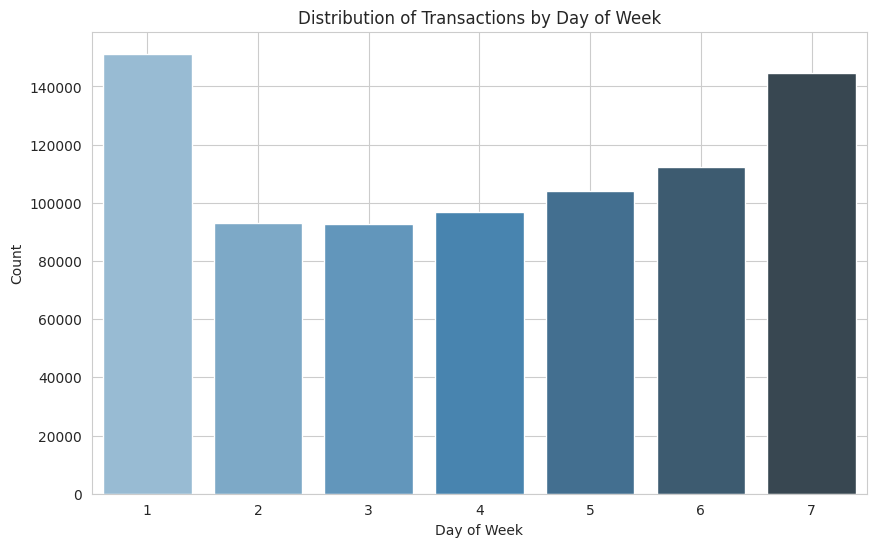

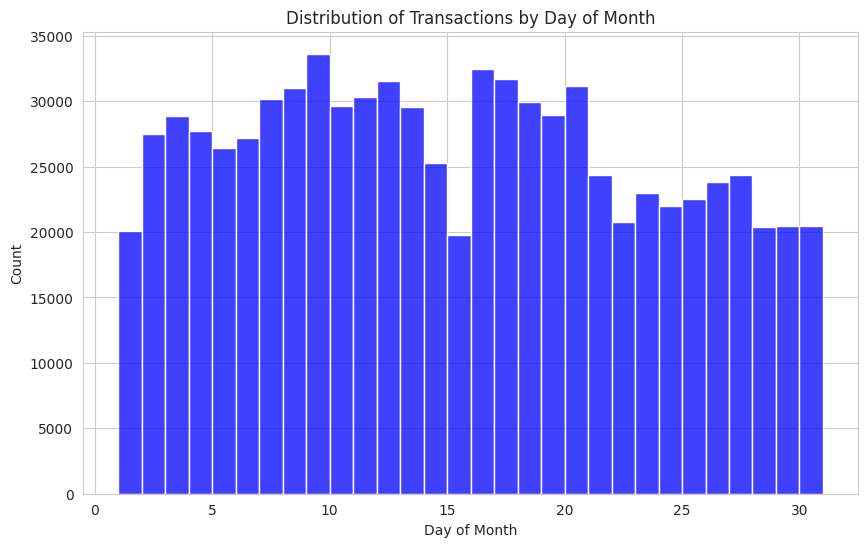

/tmp/ipykernel_77523/3233184666.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Blues_d")


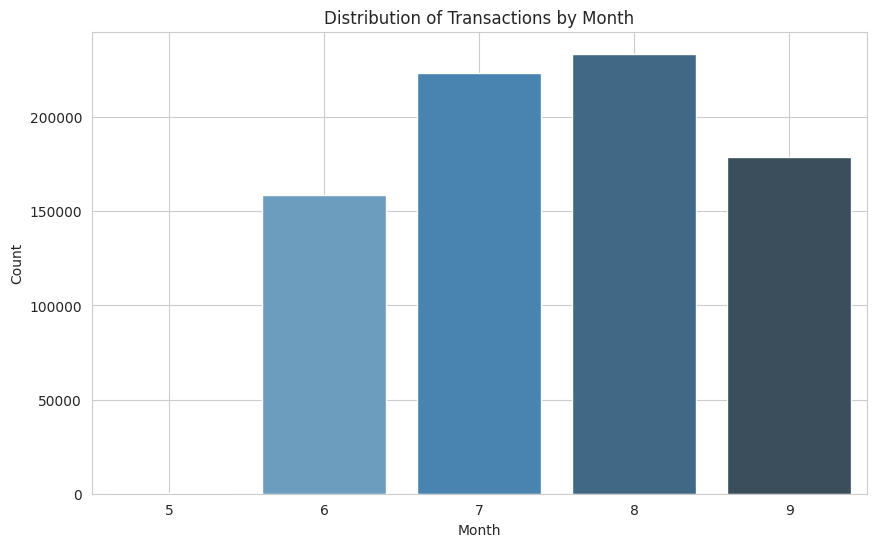

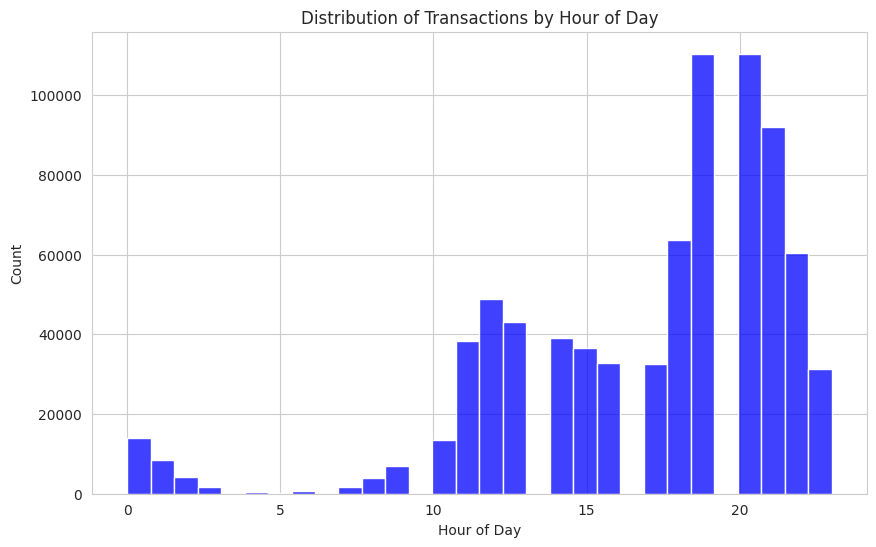

/tmp/ipykernel_77523/3233184666.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Blues_d")


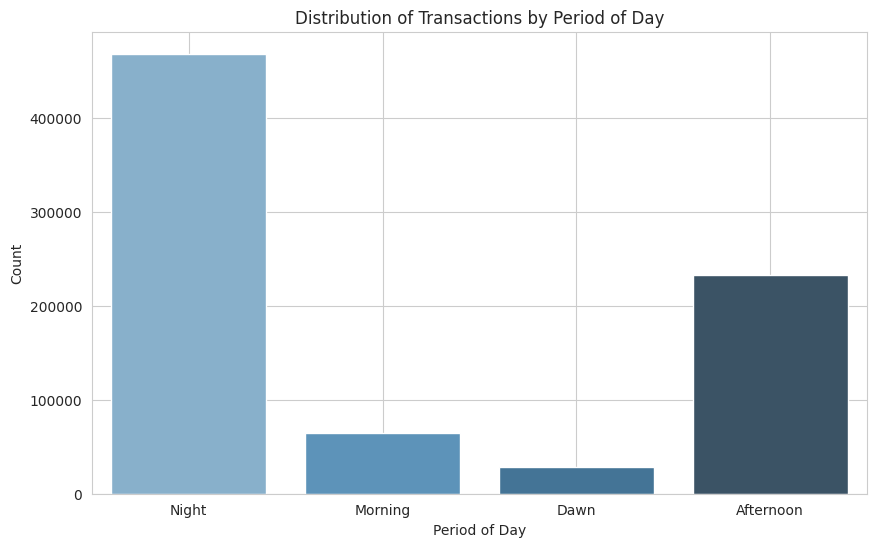

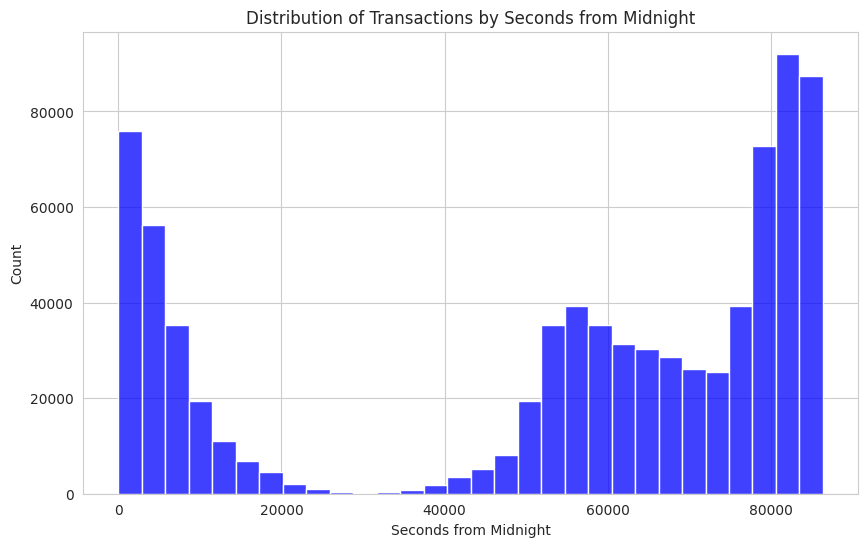

/tmp/ipykernel_77523/3233184666.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=time_col, y=value_col, data=df, ci=None)


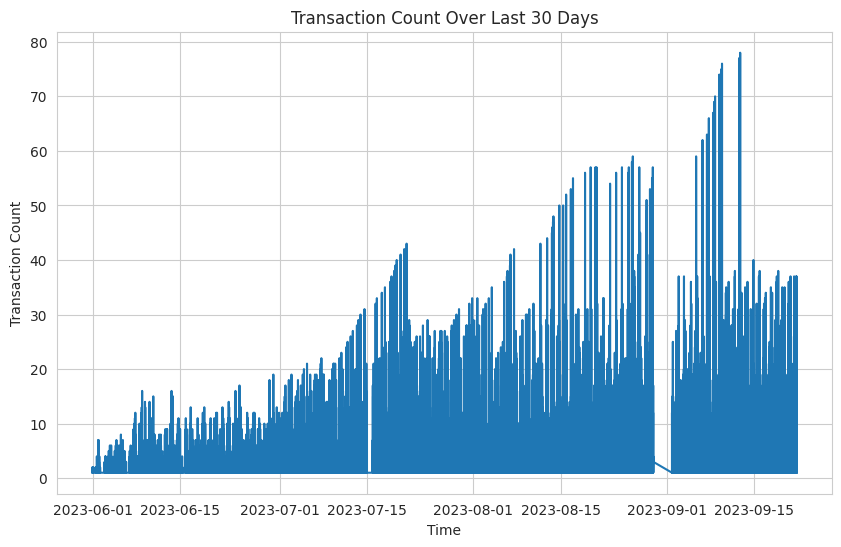

In [37]:
# 1. Day of the Week Distribution
plot_bar(data_pd, 'day_of_week', 'Distribution of Transactions by Day of Week', 'Day of Week', 'Count')

# 2. Day of the Month Distribution
plot_histogram(data_pd, 'day_of_month', 'Distribution of Transactions by Day of Month', 'Day of Month', 'Count')

# 3. Month Distribution
plot_bar(data_pd, 'month', 'Distribution of Transactions by Month', 'Month', 'Count')

# 4. Hour of the Day Distribution
plot_histogram(data_pd, 'hour_of_day', 'Distribution of Transactions by Hour of Day', 'Hour of Day', 'Count')

# 5. Period of the Day Distribution
plot_bar(data_pd, 'day_period', 'Distribution of Transactions by Period of Day', 'Period of Day', 'Count')

# 6. Seconds from Midnight Distribution
plot_histogram(data_pd, 'seconds_from_midnight', 'Distribution of Transactions by Seconds from Midnight', 'Seconds from Midnight', 'Count')

# 7. Transaction Count Over Last 30 Days
plot_time_series(data_pd, 'timestamp', 'transaction_count_last_30_days', 'Transaction Count Over Last 30 Days', 'Time', 'Transaction Count')

#### Chargeback Distribution by Day of the Week
The following plot shows how chargebacks are distributed across the days of the week. By visualizing this, we aim to identify if chargebacks tend to occur more frequently on specific days, which could point to transaction behaviors or patterns linked to certain times of the week.

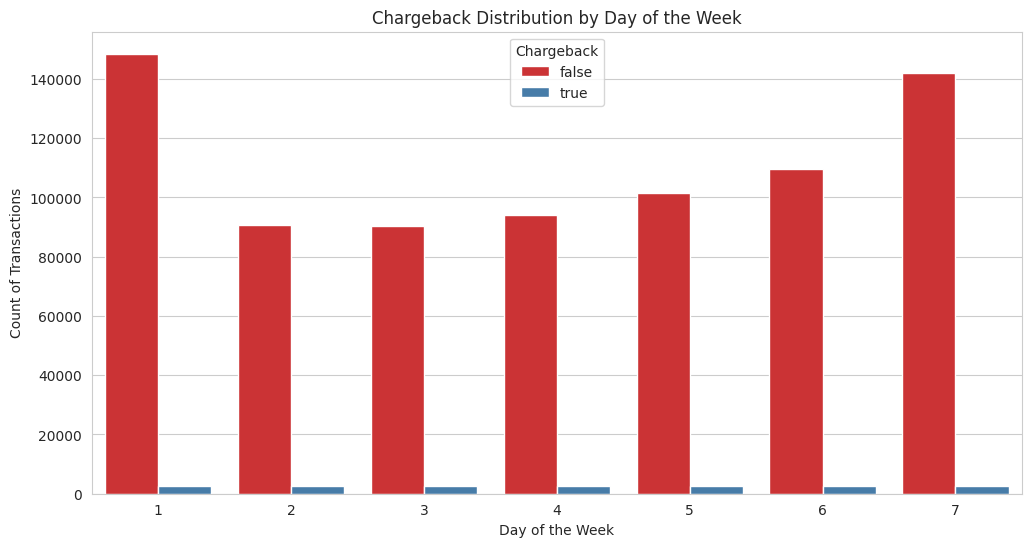

In [35]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data_pd, x='day_of_week', hue='chargeback', palette='Set1')
plt.title('Chargeback Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count of Transactions')
plt.legend(title='Chargeback')
plt.show()

### Categorical features

Columns such as `id`, `device_id`, `account_id`, and possibly `installation_id` might not bring meaningful value to your analysis or predictive modeling. These columns typically represent unique identifiers and don't contribute to the patterns or relationships we're trying to model (e.g., predicting chargebacks).

In [11]:
raw_data.agg(*(F.countDistinct(col(c)).alias(c) for c in ["id", "device_id", "account_id", "installation_id"])).show()

24/10/05 11:03:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/05 11:03:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/05 11:03:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/05 11:03:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/05 11:03:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/05 11:03:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/05 11:03:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/05 11:03:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/10/05 11:03:28 WARN RowBasedKeyValueBatch: Calling spill() on

+------+---------+----------+---------------+
|    id|device_id|account_id|installation_id|
+------+---------+----------+---------------+
|795021|   712902|    720256|         718158|
+------+---------+----------+---------------+



In [13]:
categorical_features = list(set(original_categorical_features) - set(["id", "device_id", "account_id", "installation_id"]))

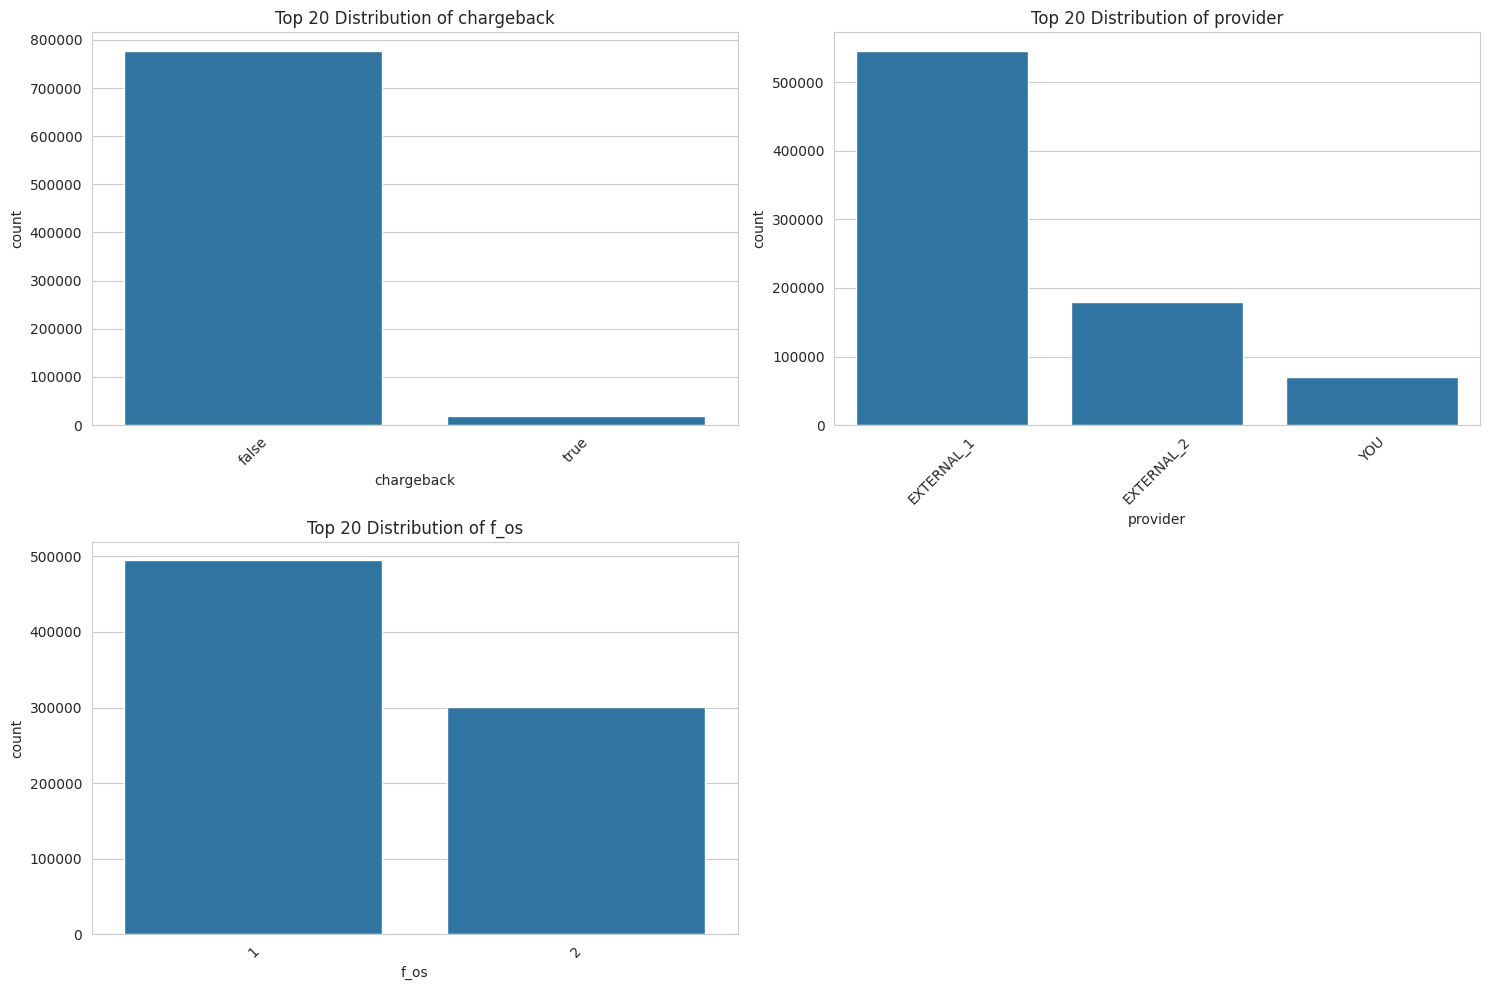

In [14]:
n_cols = 2
num_plots = len(categorical_features)
n_rows = math.ceil(num_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for idx, col in enumerate(categorical_features):
    counts = raw_data.groupBy(col).count().orderBy('count', ascending=False).limit(20).toPandas()
    sns.barplot(x=col, y='count', data=counts, ax=axes[idx])
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_title(f"Top 20 Distribution of {col}")

for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

- The imbalance distribution of chargeback suggests that the class will need to be handled carefully during modeling, possibly using techniques like **oversampling**, **undersampling**, **class weighting**, or even treating the problem as **anomaly detection** to prevent the model from being biased toward predicting the majority class (false).

- The `f_os` column appears to have two distinct values, likely representing different operating systems (OS). One OS is dominant, with approximately twice the number of transactions compared to the second OS. This could indicate that the majority of users are using one operating system over another. It’s important to investigate if there is any correlation between the OS and chargebacks, as certain OS users might be more prone to fraudulent activities or chargebacks.

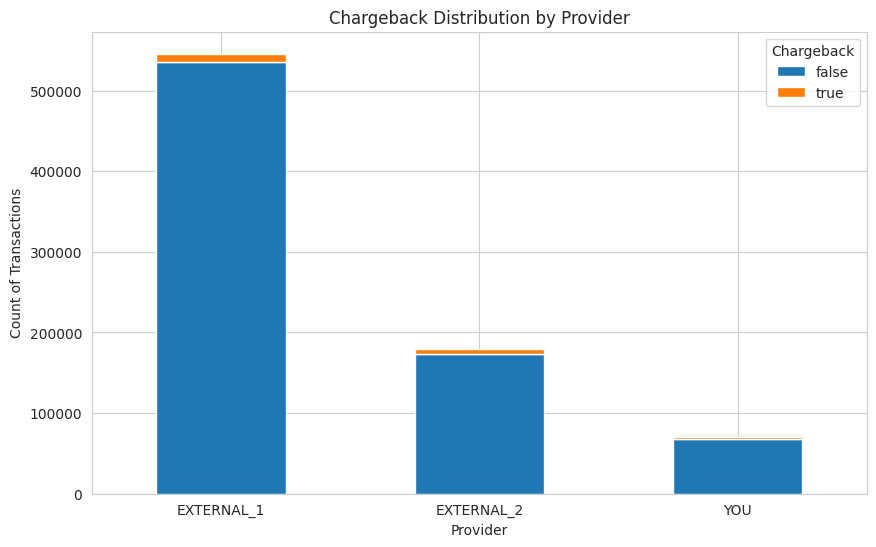

In [15]:
# Group by provider and chargeback, and count the occurrences
chargeback_by_provider_df = raw_data.groupBy("provider", "chargeback").count().toPandas()

# Pivot the data for stacked bar plotting
chargeback_by_provider_pivot = chargeback_by_provider_df.pivot(index='provider', columns='chargeback', values='count')

# Plot stacked bar
chargeback_by_provider_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Chargeback Distribution by Provider')
plt.xlabel('Provider')
plt.ylabel('Count of Transactions')
plt.xticks(rotation=0)
plt.legend(title='Chargeback')
plt.show()

In [18]:
from scipy.stats import chi2_contingency

# Select relevant categorical columns
categorical_data = raw_data.select(*categorical_features).toPandas()

# Function to calculate Cramér's V for two categorical variables
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(k-1, r-1))))

# Calculate Cramér's V for each pair of categorical variables
for col1 in categorical_features:
    for col2 in categorical_features:
        if col1 != col2:
            v = cramers_v(categorical_data[col1], categorical_data[col2])
            print(f"Cramér's V between {col1} and {col2}: {v:.4f}")

Cramér's V between chargeback and provider: 0.0362
Cramér's V between chargeback and f_os: 0.0045
Cramér's V between provider and chargeback: 0.0362
Cramér's V between provider and f_os: 0.0114
Cramér's V between f_os and chargeback: 0.0045
Cramér's V between f_os and provider: 0.0114


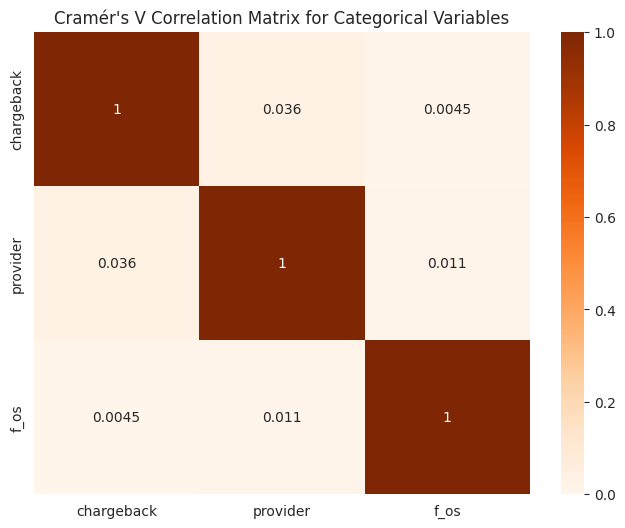

In [20]:
# Create a matrix to hold Cramér's V values
v_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)

# Fill the matrix with Cramér's V values
for col1 in categorical_features:
    for col2 in categorical_features:
        if col1 == col2:
            v_matrix.loc[col1, col2] = 1.0
        else:
            v_matrix.loc[col1, col2] = cramers_v(categorical_data[col1], categorical_data[col2])

# Convert to numeric matrix
v_matrix = v_matrix.astype(float)

# Plot the Cramér's V heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(v_matrix, annot=True, cmap=plt.cm.Oranges, vmin=0, vmax=1)
plt.title('Cramér\'s V Correlation Matrix for Categorical Variables')
plt.show()

Both features (`f_os` and `provider`) show weak correlation with each other and the target variable, which means they may not be strong predictors.

### Numerical features

In [111]:
# Sampling to reduce the data size
df = raw_data.sample(withReplacement=False, fraction=0.1, seed=None).toPandas()

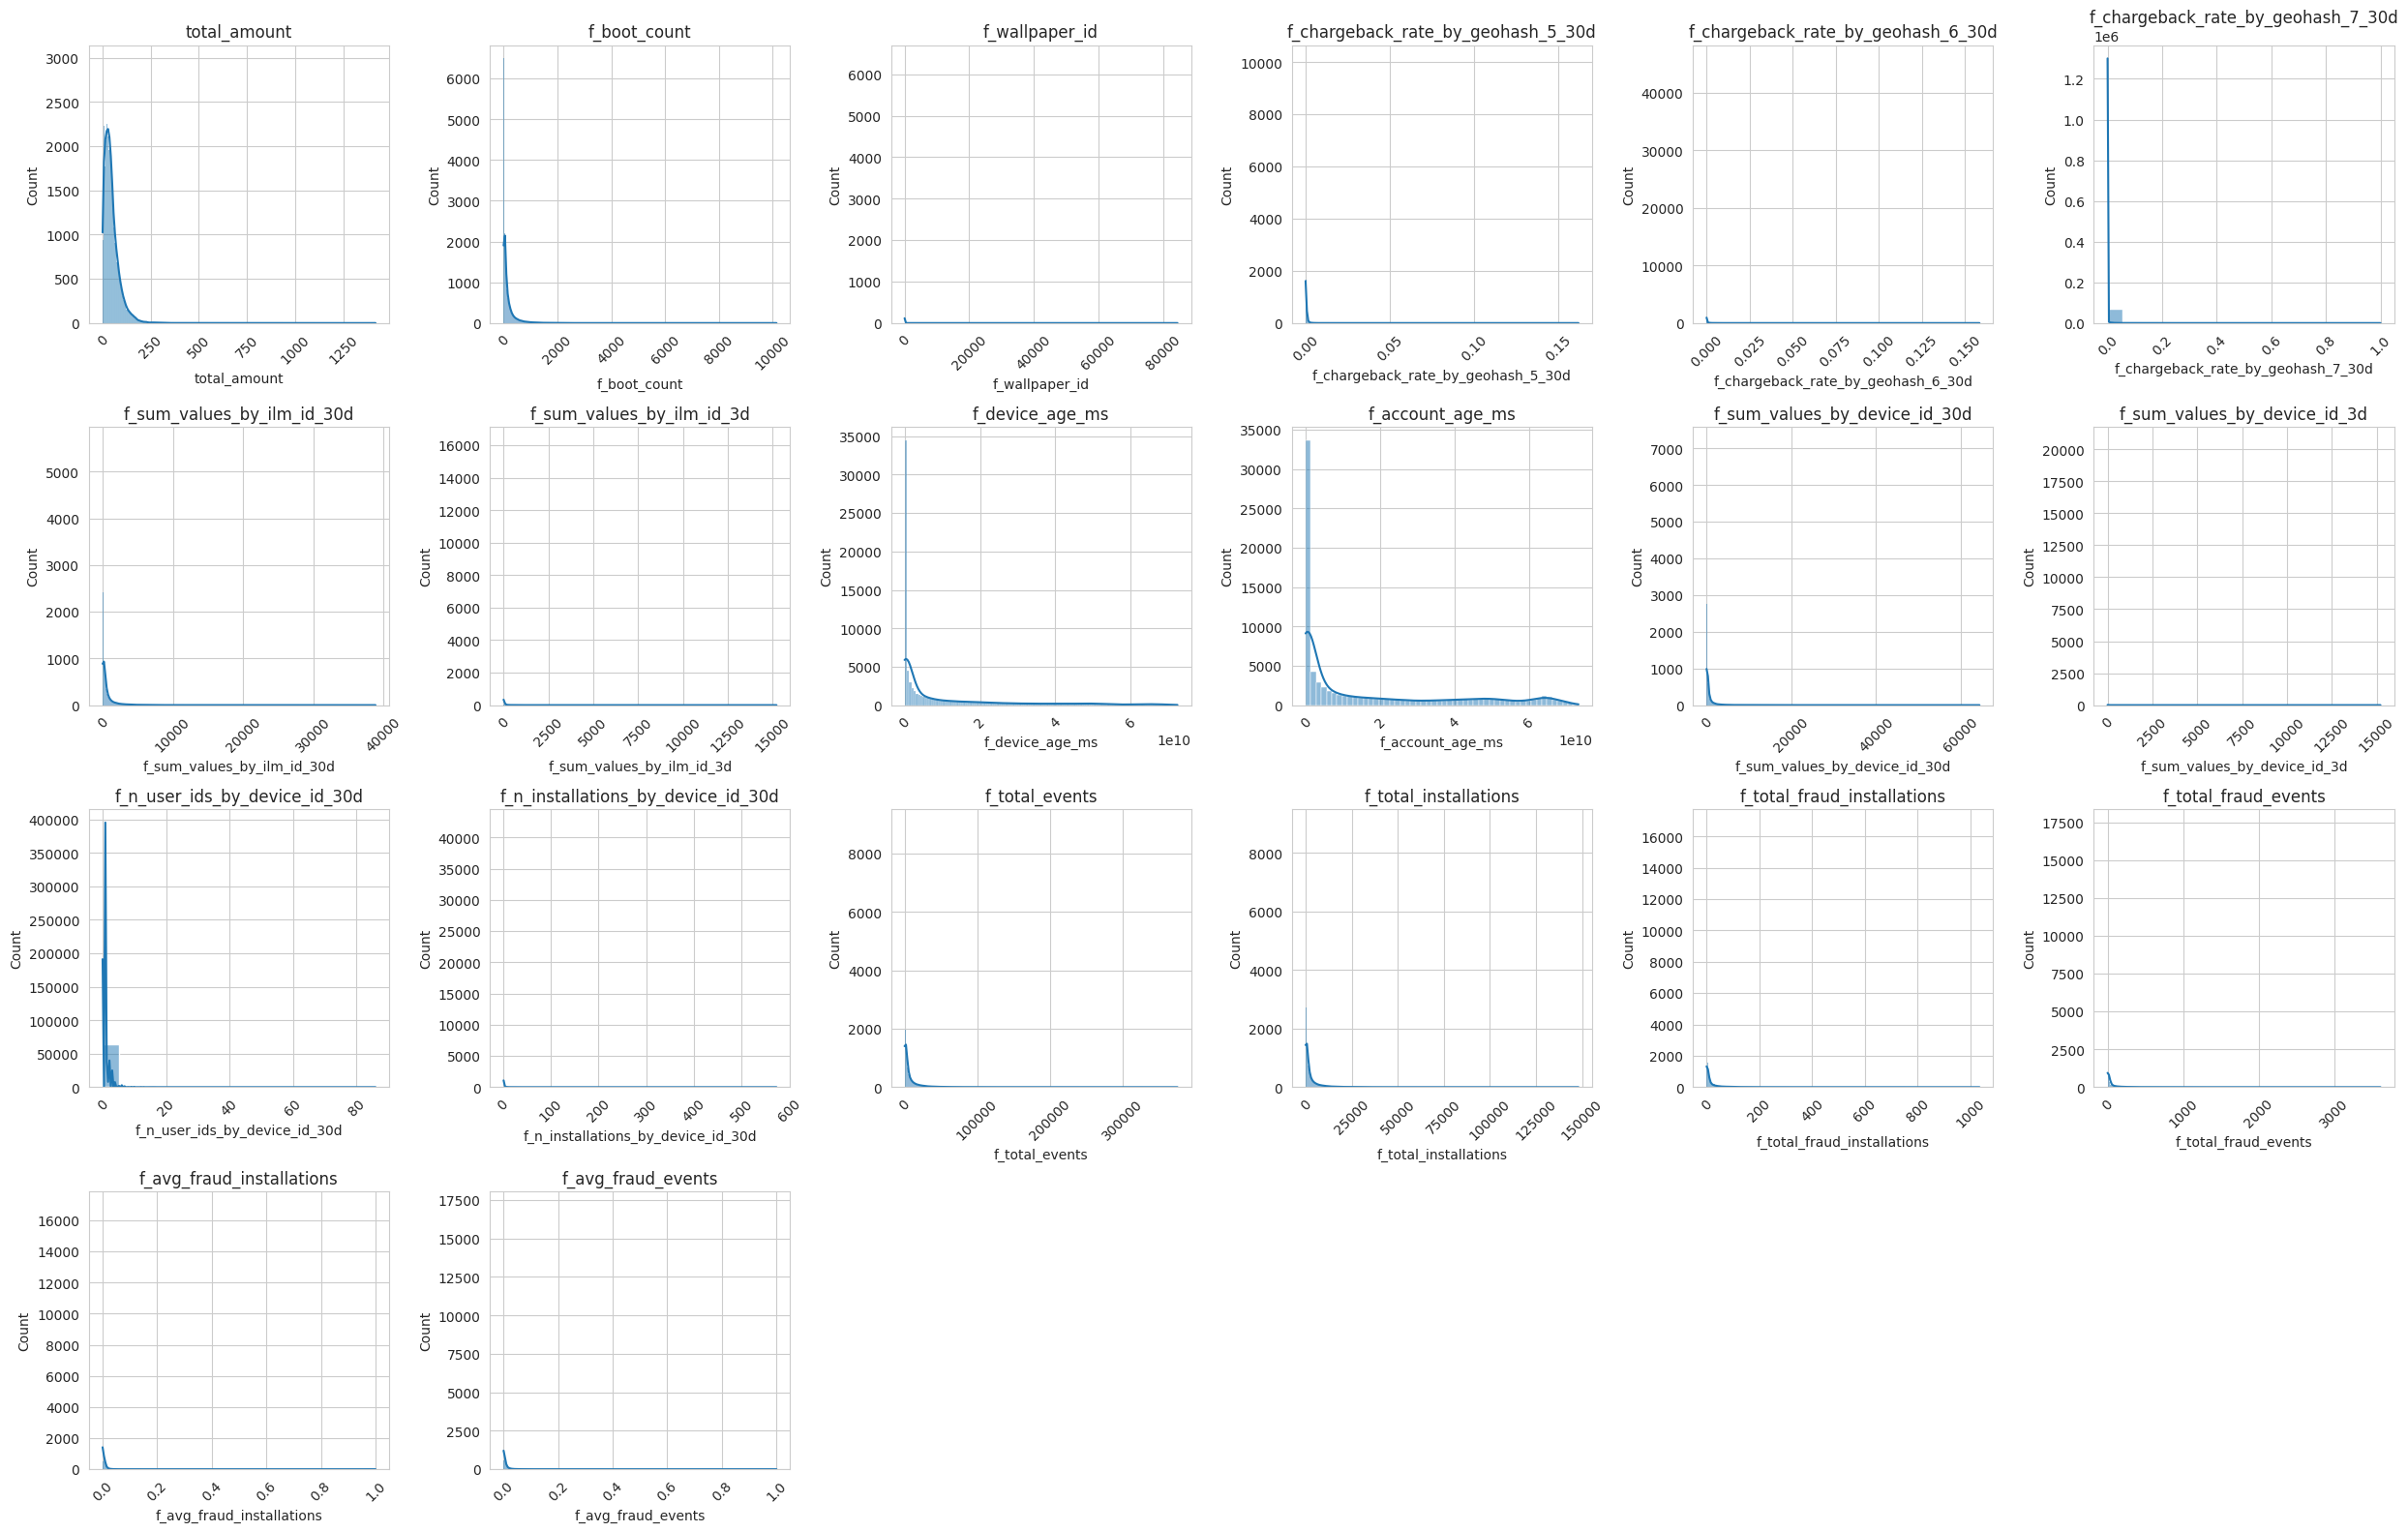

In [86]:
# Create a grid of subplots dynamically based on the number of relevant features
features_per_plot = 6
num_plots = len(numerical_features)
rows = int(np.ceil(num_plots / features_per_plot))

fig, axes = plt.subplots(rows, features_per_plot, figsize=(25, rows * 4))
axes = axes.flatten()

# Iterate over each feature and plot its distribution
for i, col in enumerate(numerical_features):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].set_title(f'{col}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(col)

# Remove unused subplots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

# Adjust space between plots to avoid title overlapping
plt.subplots_adjust(hspace=1.0, wspace=0.4)
plt.tight_layout()
plt.show()

- Transaction Amounts: A right-skewed distribution for features like `total_amount` and others related to transaction values means most transactions are of lower amounts, with a few high-values. This could be typical in financial data where small transactions dominate, but high-value transactions need further attention as they may carry higher risks (e.g., potential fraud).

- Fraud Features: Skewness in features such as `f_total_fraud_events`, `f_total_fraud_installations`, and `f_avg_fraud_events` suggests that most devices or accounts have low or no fraudulent activity, while a few have a high concentration of fraud-related activities.

- For features like `f_account_age_ms` or `f_device_age_ms`, right skewness indicates that most devices or accounts are relatively new, with a smaller number of older ones. This could imply that your dataset includes more recent accounts or devices, and the older ones may behave differently or have different risk profiles.

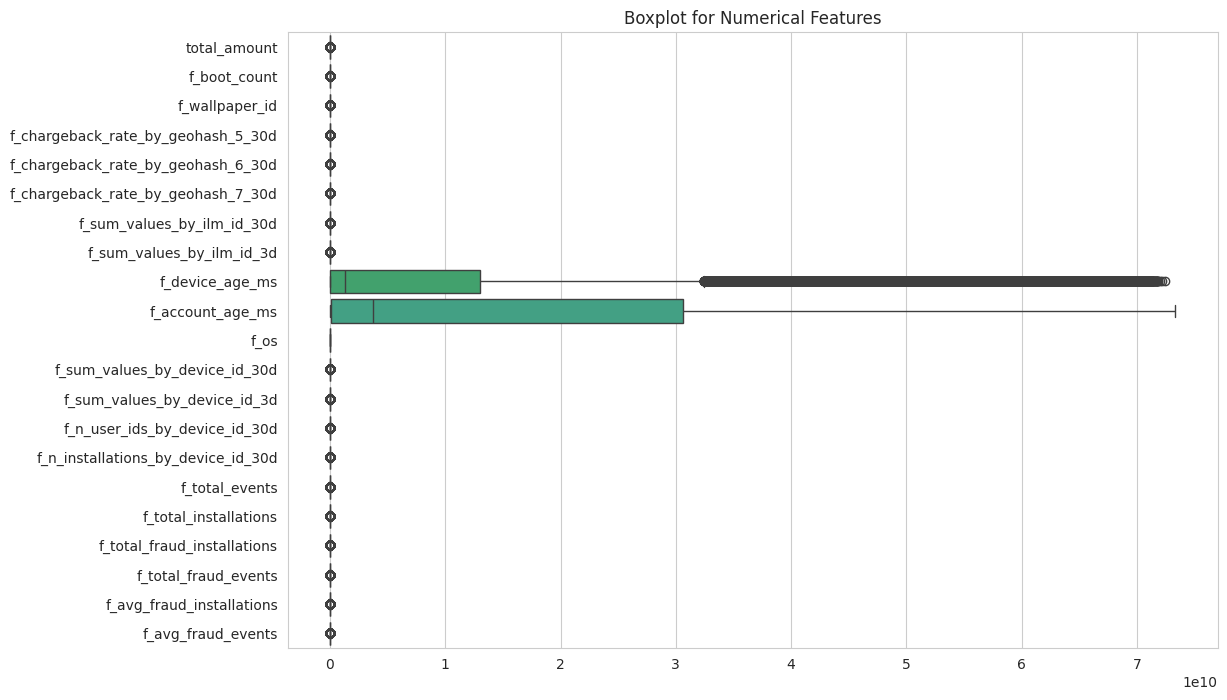

In [87]:
# Plot boxplots for the relevant features
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, orient="h")
plt.title('Boxplot for Numerical Features')
plt.show()

24/10/03 15:45:00 WARN Executor: Managed memory leak detected; size = 78768370 bytes, task 10.0 in stage 226.0 (TID 1632)
24/10/03 15:45:02 WARN Executor: Managed memory leak detected; size = 167235390 bytes, task 0.0 in stage 226.0 (TID 1631)
24/10/03 15:45:21 WARN Executor: Managed memory leak detected; size = 78768370 bytes, task 10.0 in stage 239.0 (TID 1676)
24/10/03 15:45:22 WARN Executor: Managed memory leak detected; size = 167235390 bytes, task 0.0 in stage 239.0 (TID 1675)


<Axes: >

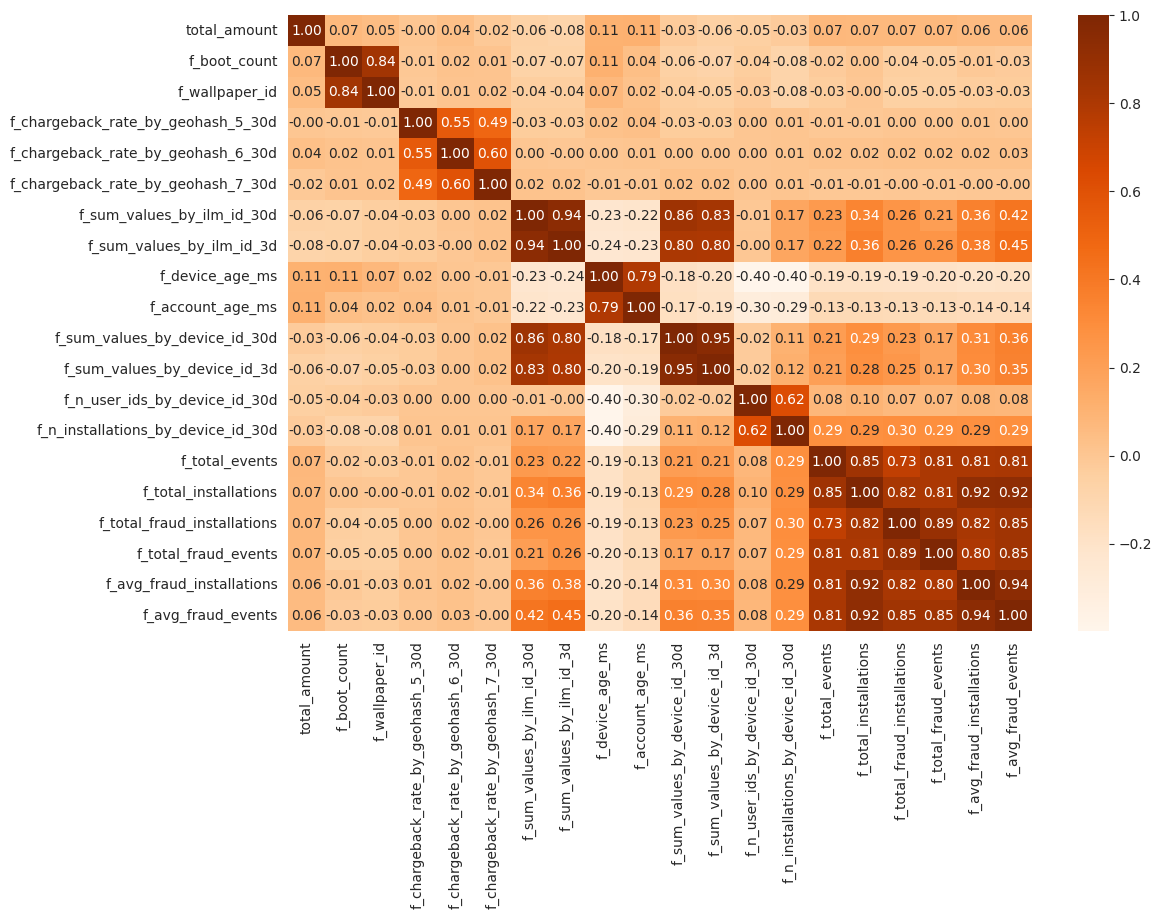

In [117]:
from pyspark.mllib.stat import Statistics
import pandas as pd

corr_data = raw_data.select(numerical_features)
# Convert the selected features into an RDD format (Resilient Distributed Dataset)
features = corr_data.rdd.map(lambda row: row[0:])
corr_mat = Statistics.corr(features, method="spearman")

corr_matrix_df = pd.DataFrame(data=corr_mat, columns=numerical_features, index=numerical_features)

plt.figure(figsize=(12, 8))  
sns.heatmap(
    corr_matrix_df, 
    xticklabels=corr_matrix_df.columns.values,
    yticklabels=corr_matrix_df.columns.values,  
    cmap=plt.cm.Oranges, 
    annot=True,
    fmt=".2f"
)

##### Highly Correlated Features (0.80 ~ 0.99):

These features are strongly related to each other, which often indicates redundancy or multicollinearity.

- `f_boot_count` and `f_wallpaper_id`:
    - The correlation between `f_wallpaper_id` (a unique ID representing the wallpaper on the device) and `f_boot_count` (the number of times the device was restarted) is quite strong. It could be that devices with certain wallpaper settings are associated with specific behaviors, such as frequent reboots, or certain types of devices might have default wallpapers that are more frequently rebooted.
    - Since `f_wallpaper_id` might be less relevant (it's more related to device appearance than behavior), maybe it can be dropped later.

- `f_sum_values_by_ilm_id_30d` and `f_sum_values_by_ilm_id_3d`:
    - The sums of transactions for the last 30 days and 3 days are highly correlated. This is expected since the 3-day total contributes directly to the 30-day total.

- `f_sum_values_by_device_id_30d` and `f_sum_values_by_device_id_3d`:
    - A similar pattern, where transaction amounts over 30 days and 3 days for a device are strongly related.

- `f_total_events` and `f_total_installations`:
    - As the number of installations at a given device location increases, the number of transactions (events) at that location also increases.
    - Locations with high number of transactions are often used by multiple devices or accounts, which leads to a higher of installations. It seems to me, that this be typical of high-traffic areas or businesses.
    
- `f_total_fraud_installations` and `f_total_fraud_events`:
    - Fraudulent installations and fraudulent events are strongly linked, indicating that more fraudulent installations lead to more fraudulent events.

- `f_total_fraud_installations` and `f_avg_fraud_events`:
    - Devices with more fraudulent installations also tend to have a higher rate of fraudulent events.
    - The relationship suggests that device's locations that have a history of fraudulent installations are consistently associated with fraudulent activities.

- `f_avg_fraud_installations` and `f_avg_fraud_events`:
    - These two averages are closely related, as fraud rates for installations and events are expected to move together.

##### Moderately Correlated Features (0.60 ~ 0.79): 

These features have a moderate relationship and can provide complementary information.

- `f_device_age_ms` and `f_account_age_ms`:
    - The age of the device and the account are highly related, indicating that users who have had their devices for longer periods tend to have older accounts as well.

- `f_n_user_ids_by_device_id_30d` and `f_n_installations_by_device_id_30d`:
    - The number of user IDs and the number of installations associated with a device over 30 days show a moderate correlation, indicating a relationship between shared devices and the number of installations. More users per device means more installations on the device.

- `f_chargeback_rate_by_geohash_6_30d` and `f_chargeback_rate_by_geohash_7_30d`:
    - Chargeback rates at different levels of geographic granularity are moderately correlated, but finer levels of geohash may capture distinct risk patterns.


To reduce the problem of multicollinearity and redundant features, It can be designed new composite features that summarize multiple dimensions of the fraudulent and general activity at each device's location.

- Fraud intensity: Combine all the features related to fraudulent installations and events to create a single score that summarizes the overall fraud intensity at a device's location.
- Transactions per installations: A ratio between the total number of events (transactions) and the total number of installations at a location. This feature tries to show the average transaction activity per installation. A high ratio may indicate a location where installations are being used more frequently for transactions, which might correlate with higher risk or profitability.
- Fraud installations per total installations: Feature that shows the proportion of installations at a location that are fraudulent.
- Fraud transactions per total transactions: A ratio of fraudulent events (transactions) to total events.